In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [6]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [7]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [8]:
y = customer_data.pop('Churn')

In [9]:
X = customer_data

In [10]:
X_dum = pd.get_dummies(X, columns=X.select_dtypes(include='object').columns, drop_first=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=1, stratify=y)

In [12]:
pipe_dt = make_pipeline(RandomOverSampler(random_state=1),
                        DecisionTreeClassifier(random_state=1))

pipe_dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                  'decisiontreeclassifier__max_depth': [5, 10, None],
                  'decisiontreeclassifier__min_samples_split': [2, 5, 9],
                  'decisiontreeclassifier__max_features': [0.3, 0.6]}

pipe_dt_gs = GridSearchCV(pipe_dt, pipe_dt_params, cv=5, n_jobs=-2, verbose=2)
pipe_dt_gs.fit(X_train, y_train)

print('Mean cross-validated score:', pipe_dt_gs.best_score_)
print('Test score:', pipe_dt_gs.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean cross-validated score: 0.7643258635632042
Test score: 0.7469194312796209


In [13]:
pipe_dt_gs.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': 0.6,
 'decisiontreeclassifier__min_samples_split': 5}

In [14]:
dt_predictions = pipe_dt_gs.predict(X_test)

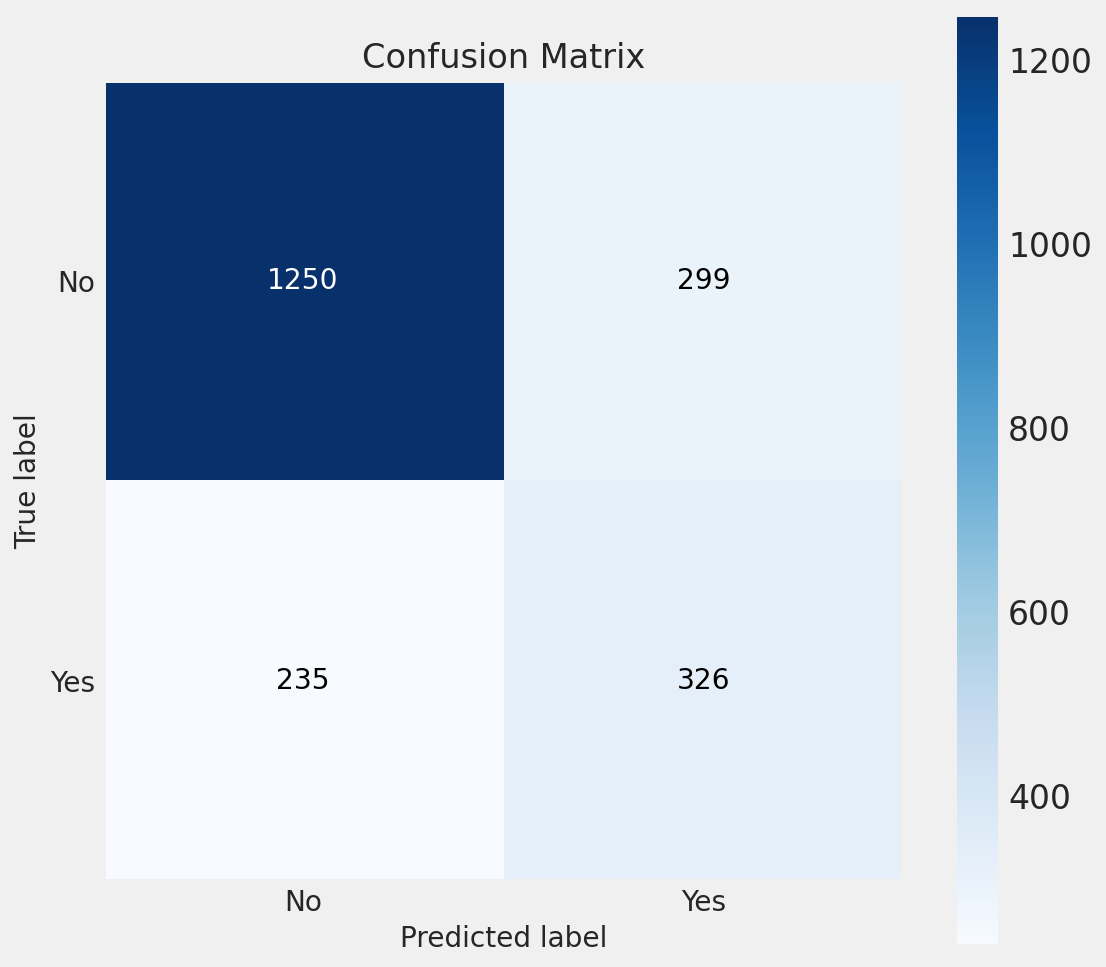

In [15]:
skplt.metrics.plot_confusion_matrix(y_test, dt_predictions, figsize=(8, 8))
plt.show()

In [16]:
pipe_lr = make_pipeline(StandardScaler(),
                        RandomOverSampler(random_state=1),
                        LogisticRegression(max_iter=10000),
                        verbose=True)

pipe_lr_params = {'logisticregression__penalty': ['elasticnet'],
                  'logisticregression__C': [0.01, 0.05, 0.5, 1, 10, 100],
                  'logisticregression__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 0.99],
                  'logisticregression__solver': ['saga'],
                  'logisticregression__fit_intercept': [True, False]}

pipe_lr_gs = GridSearchCV(pipe_lr, pipe_lr_params, cv=5, n_jobs=-3, verbose=1)
pipe_lr_gs.fit(X_train, y_train)

print('Mean cross-validated score:', pipe_lr_gs.best_score_)
print('Test score:', pipe_lr_gs.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.5s
[Pipeline] . (step 2 of 3) Processing randomoversampler, total=   0.2s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=27.2min
Mean cross-validated score: 0.7980510503074574
Test score: 0.8052132701421801


In [17]:
pipe_lr_gs.best_params_

{'logisticregression__C': 0.5,
 'logisticregression__fit_intercept': True,
 'logisticregression__l1_ratio': 0.5,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__solver': 'saga'}

In [18]:
lr_predictions = pipe_lr_gs.predict(X_test)

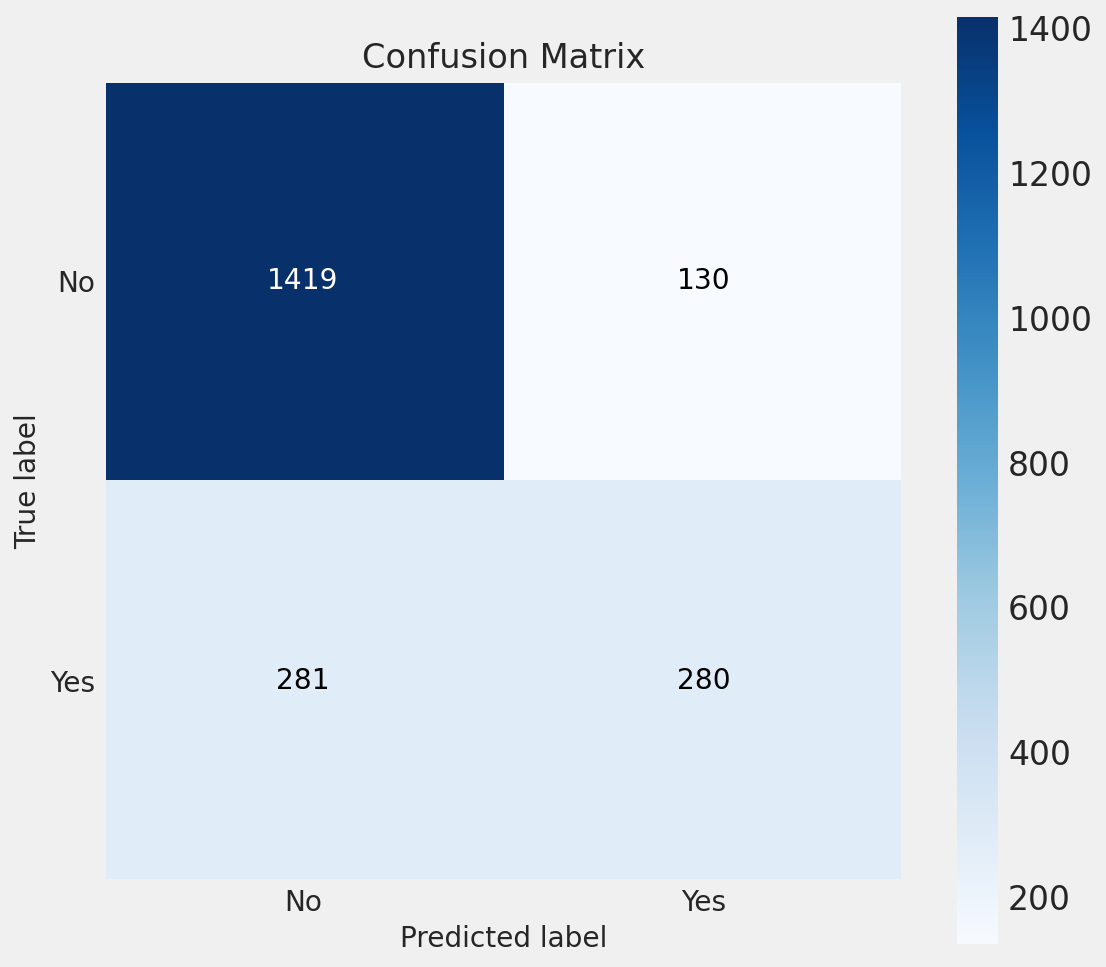

In [19]:
skplt.metrics.plot_confusion_matrix(y_test, lr_predictions, figsize=(8, 8))
plt.show()